# Lesson 2 - Bayesian Optimization

## Lesson Video:

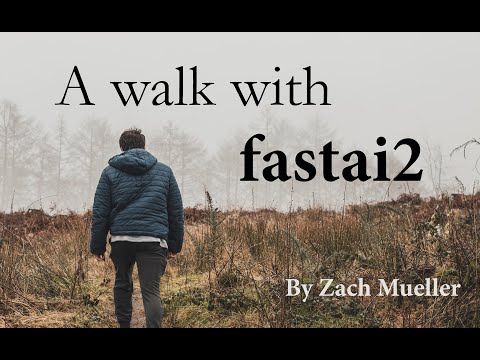

In [ ]:
#hide_input
from IPython.lib.display import YouTubeVideo
from datetime import timedelta
start = int(timedelta(minutes=48, seconds=7).total_seconds())
YouTubeVideo('-aCtDIgbxMw', start=start)

In [ ]:
#hide
#Run once per session
!pip install fastai wwf bayesian-optimization -q --upgrade

In [ ]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf', 'bayesian-optimization'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `wwf`, and `bayesian-optimization` currently running at the time of writing this:
* `fastai`: 2.1.10 
* `fastcore`: 1.3.13 
* `wwf`: 0.0.8 
* `bayesian-optimization`: 1.2.0 
---

In [ ]:
from fastai.tabular.all import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def fit_with(lr:float, wd:float, dp:float):
  # create a Learner
  config = tabular_config(embed_p=dp, ps=wd)
  learn = tabular_learner(data, layers=[200,100], metrics=accuracy, config=config)
  
  # Train for x epochs
  with learn.no_bar():
    learn.fit_one_cycle(3, lr)
    
  # Save, print, and return the overall accuracy
  acc = float(learn.validate()[1])
  
  return acc

Let's adjust this further to show how we would go about adjusting the learning rate, embedded weight decay, drop out, and layer size:

In [ ]:
def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float):

  print(lr, wd, dp)
  if int(n_layers) == 2:
    layers = [int(layer_1), int(layer_2)]
  elif int(n_layers) == 3:
    layers = [int(layer_1), int(layer_2), int(layer_3)]
  else:
    layers = [int(layer_1)]
  config = tabular_config(embed_p=float(dp),
                          ps=float(wd))
  learn = tabular_learner(dls, layers=layers, metrics=accuracy, config = config)

  with learn.no_bar() and learn.no_logging():
    learn.fit(5, lr=float(lr))

  acc = float(learn.validate()[1])

  return acc

Let's try it out

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()
splits = RandomSplitter()(range_of(df))

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

In [ ]:
dls = to.dataloaders(bs=512)

We'll declare our hyper-parameters:

In [ ]:
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.4),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (50, 200),
       'layer_2': (100, 1000),
       'layer_3': (200, 2000)}

And now we build the optimizer:

In [ ]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent
    random_state=1
)

And now we can search!

In [ ]:
%time optim.maximize(n_iter=10)

We can grab the best results:

In [ ]:
print(optim.max)

{'target': 0.8404483795166016, 'params': {'dp': 0.1710613610736308, 'layer_1': 57.63154958927875, 'layer_2': 100.1567384765859, 'layer_3': 1930.4092799350558, 'lr': 0.0721697277771627, 'n_layers': 2.868052690189961, 'wd': 0.035039066808375346}}


And with a few conversions we see:

* The best number of layers was 2
* The first layer a size of 57
* The second layer a size of 100
And then of course our other hyper paramters